In [1]:
pip install -q ffmpeg-python


Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install tensorflow_addons

  Obtaining dependency information for tensorflow_addons from https://files.pythonhosted.org/packages/ec/52/047d768c4669db0c059109a88c21a3c71bcda957c46f13967e44b8c7fa4c/tensorflow_addons-0.22.0-cp311-cp311-win_amd64.whl.metadata
  Using cached tensorflow_addons-0.22.0-cp311-cp311-win_amd64.whl.metadata (1.8 kB)
  Using cached typeguard-2.13.3-py3-none-any.whl (17 kB)
Using cached tensorflow_addons-0.22.0-cp311-cp311-win_amd64.whl (719 kB)
Note: you may need to restart the kernel to use updated packages.


In [51]:
import warnings
warnings.filterwarnings('ignore')
import cv2
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import seaborn as sns
import random
import ffmpeg
from IPython.display import Video
from tqdm import tqdm
import tensorflow as tf
import tensorflow_addons as tfa
import logging
from itertools import cycle

logging.disable(logging.WARNING)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 


plt.style.use('ggplot')
cm = sns.light_palette("green", as_cmap=True)
pd.option_context('display.max_colwidth', 100)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

In [52]:
# SEED EVERYTHING
random.seed(hash("setting random seeds") % 2**32 - 1)
np.random.seed(hash("improves reproducibility") % 2**32 - 1)

# config
class config:
    BASE_DIR = r"C:\Users\SURUJ_KALITA\Desktop\Under-Water-image-Enhancement\Ptroject\underwater-image-enhancement-main\sea-thru\trainimages"

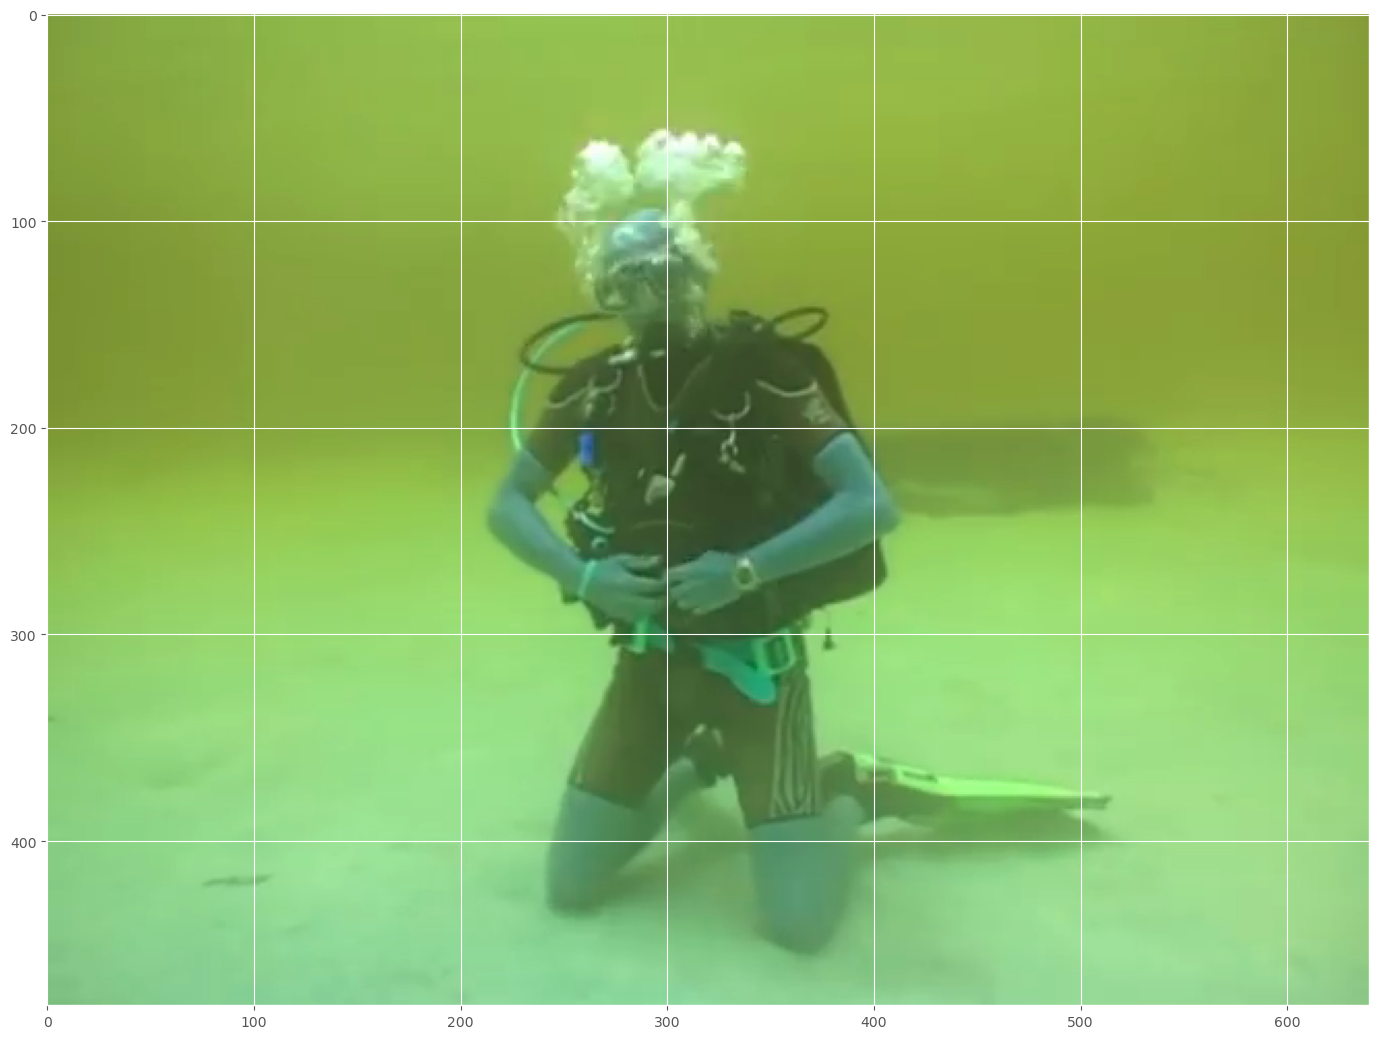

In [53]:
img_og = plt.imread(r'C:\Users\SURUJ_KALITA\Desktop\Under-Water-image-Enhancement\Ptroject\underwater-image-enhancement-main\sea-thru\trainimages\hazy_test\807.png')
img_9101 = cv2.imread(r'C:\Users\SURUJ_KALITA\Desktop\Under-Water-image-Enhancement\Ptroject\underwater-image-enhancement-main\sea-thru\trainimages\hazy_test\807.png')
plt.imshow(img_9101)

<Figure size 1200x1500 with 0 Axes>

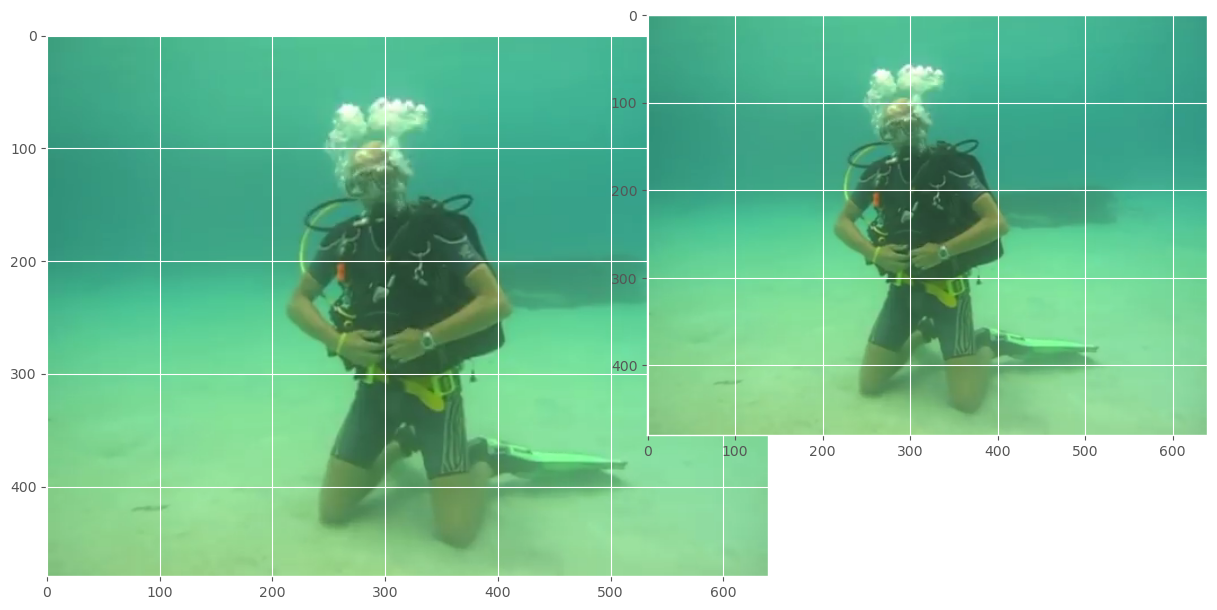

In [54]:
plt.figure(figsize = (12,15))


plt.rcParams["figure.figsize"] = [20.00, 10.50]
plt.rcParams["figure.autolayout"] = True
im = plt.imread(r'C:\Users\SURUJ_KALITA\Desktop\Under-Water-image-Enhancement\myenv\trainimages\hazy_test\807.png') # insert local path of the image.
fig, ax = plt.subplots(figsize=(20,6))

ax.imshow(plt.imread(r"C:\Users\SURUJ_KALITA\Desktop\Under-Water-image-Enhancement\myenv\trainimages\hazy_test\807.png"));
newax = fig.add_axes([0.3,0.3,0.6,0.7], anchor='NE', zorder=1)
newax.imshow(im);

newax.axis('ON')
plt.show();

In [55]:
img_demo = img_9101

In [56]:
def he_hsv(img_demo):
    img_hsv = cv2.cvtColor(img_demo, cv2.COLOR_RGB2HSV)

    # Histogram equalisation on the V-channel
    img_hsv[:, :, 2] = cv2.equalizeHist(img_hsv[:, :, 2])

    # convert image back from HSV to RGB
    image_hsv = cv2.cvtColor(img_hsv, cv2.COLOR_HSV2RGB)
    
    return

In [57]:
img_dir = (r'C:\Users\SURUJ_KALITA\Desktop\Under-Water-image-Enhancement\myenv\trainimages\hazy_test')

In [58]:
def plot_img(img_dir,num_items,func,mode):
    img_list = random.sample(os.listdir(img_dir), num_items)

    for i in range(len(img_list)):
        full_path = img_dir + '/' + img_list[i]
        img_temp1 = plt.imread(full_path)
        img_temp_cv = cv2.imread(full_path)
        plt.figure(figsize=(20,15))
        plt.subplot(1,2,1)
        plt.imshow(img_temp1);
        plt.subplot(1,2,2)
        if mode == 'plt':
            plt.imshow(func(img_temp1));
        elif mode == 'cv2':
            plt.imshow(func(img_temp_cv));

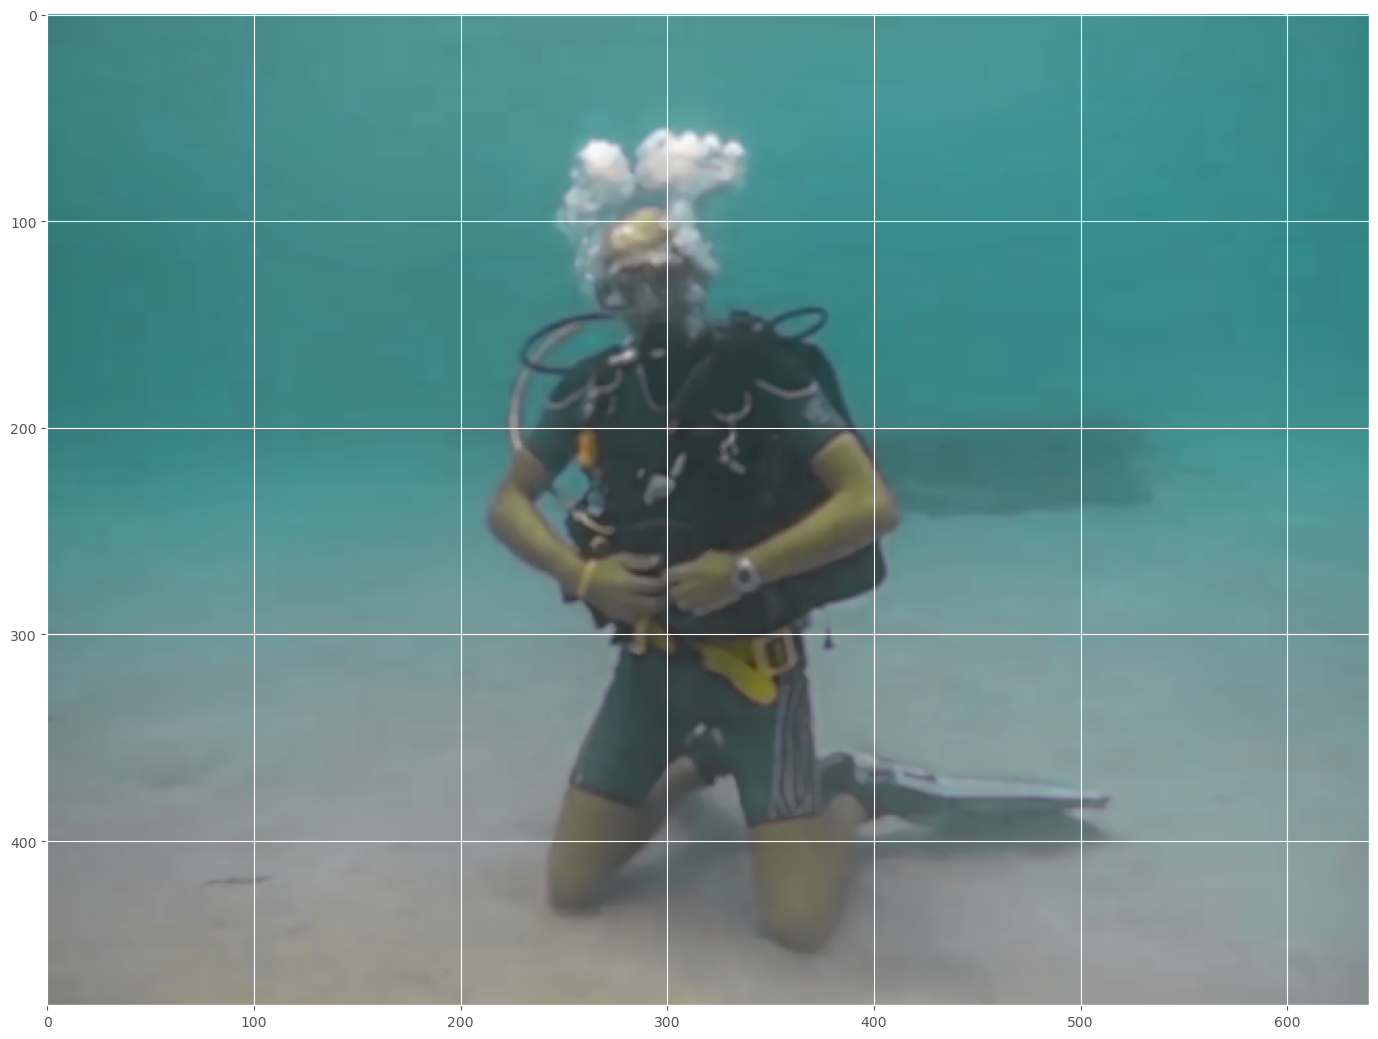

In [59]:
from skimage import io , img_as_ubyte
import numpy as np
from matplotlib import pyplot as plt 
from scipy import ndimage



gaussian_filter = ndimage.gaussian_filter(image2, sigma=11)
plt.imshow(gaussian_filter)
image2 = io.imread(r"C:\Users\SURUJ_KALITA\Desktop\Under-Water-image-Enhancement\myenv\trainimages\hazy_test\807.png")
plt.imshow(image2)
median_filter = ndimage.median_filter(image2 , 3)
plt.imshow(median_filter)

In [38]:
import os
import cv2
import numpy as np

In [60]:
def dark_channel(image, window_size=15):
    padded_image = cv2.copyMakeBorder(image, window_size // 2, window_size // 2, window_size // 2, window_size // 2, cv2.BORDER_CONSTANT)
    dark_channel = np.min(padded_image, axis=2)
    return dark_channel[window_size // 2 : -window_size // 2, window_size // 2 : -window_size // 2]

In [65]:
def atmospheric_light(image, dark_channel, percentile=0.001):
    flat_dark_channel = dark_channel.flatten()
    num_pixels = flat_dark_channel.shape[0]
    
    # Determine the number of pixels to select
    num_pixels_to_select = max(1, int(num_pixels * percentile))
    
    # If the number of pixels to select exceeds the total number of pixels, select all pixels
    if num_pixels_to_select >= num_pixels:
        num_pixels_to_select = num_pixels
    
    indices = np.argpartition(flat_dark_channel, -num_pixels_to_select)[-num_pixels_to_select:]
    atmospheric_light = np.max(image.reshape(-1, 3)[indices], axis=0)
    return atmospheric_light



In [66]:
def transmission_estimation(image, atmospheric_light, omega=0.95, window_size=15):
    normalized_image = image / atmospheric_light
    dark_chan = dark_channel(normalized_image, window_size)
    transmission_map = 1.0 - omega * dark_chan
    return transmission_map


In [67]:
def guided_filter(I, p, r=15, eps=1e-3):
    mean_I  = cv2.boxFilter(I, -1, (r, r))
    mean_p  = cv2.boxFilter(p, -1, (r, r))
    corr_I  = cv2.boxFilter(I * I, -1, (r, r))
    corr_Ip = cv2.boxFilter(I * p, -1, (r, r))

    var_I = corr_I - mean_I * mean_I
    cov_Ip = corr_Ip - mean_I * mean_p

    a = cov_Ip / (var_I + eps)
    b = mean_p - a * mean_I

    mean_a = cv2.boxFilter(a, -1, (r, r))
    mean_b = cv2.boxFilter(b, -1, (r, r))

    q = mean_a * I + mean_b
    return q

In [68]:
def dehaze(image, omega=0.95, window_size=15, t_min=0.1):
    dark_chan = dark_channel(image, window_size)
    atmospheric = atmospheric_light(image, dark_chan)
    transmission = transmission_estimation(image, atmospheric, omega, window_size)
    transmission = np.maximum(transmission, t_min)
    
    # Resize the transmission map to match the shape of the input image
    transmission_resized = cv2.resize(transmission, (image.shape[1], image.shape[0]))
    
    # Expand dimensions of the transmission map to match number of channels in the input image
    transmission_expanded = np.repeat(transmission_resized[:, :, np.newaxis], 3, axis=2)
    
    refined_transmission = guided_filter(image.astype(np.float32)/255.0 , transmission_expanded.astype(np.float32))

    recovered_image = np.zeros_like(image)
    
    for i in range(3):
        recovered_image[:, :, i] = ((image[:, :, i] - atmospheric[i]) / refined_transmission[:, :, i] + atmospheric[i]).astype(np.uint8)

    return np.clip(recovered_image.astype(np.uint8), 0 ,255)

In [69]:
# Get the current directory
current_directory = os.getcwd()

desired_folder = r'C:\Users\SURUJ_KALITA\Desktop\Under-Water-image-Enhancement\Ptroject\underwater-image-enhancement-main\sea-thru\folder'
os.chdir(desired_folder)

# Define input and output folder paths
input_folder = os.path.join(current_directory, 'Input')
output_folder = os.path.join(current_directory, 'Output')

# Create the output folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# List all image files in the input folder
image_files = [f for f in os.listdir(input_folder) if f.endswith(('.jpg', '.jpeg', '.png', '.bmp'))]

for image_file in image_files:
    # Load the underwater image
    input_image_path = os.path.join(input_folder, image_file)
    input_image = cv2.imread(input_image_path)

    # Enhance the image using the Dark Channel Prior
    enhanced_image = dehaze(input_image)

    # Save the enhanced image to the output folder within the input folder
    output_image_path = os.path.join(output_folder, image_file)
    cv2.imwrite(output_image_path, enhanced_image)

print("Enhancement complete. Enhanced images are saved in the 'Output' folder within the 'Input' folder.")

Enhancement complete. Enhanced images are saved in the 'Output' folder within the 'Input' folder.


In [70]:
####https://github.com/hainh/sea-thru/blob/master/seathru.py
##https://www.kaggle.com/code/soumya9977/learning-to-sea-underwater-img-enhancement-eda

In [ ]:
im